In [ ]:
! pip install wandb           

In [1]:
from google.colab import drive 
drive.mount('/content/drive')            

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# from PIL import Image
# import numpy as np
# im = Image.open('/content/drive/My Drive/Colab Notebooks/Cat_Dog/001/dog.12437.jpg')
# image = np.asarray(im)

# # from matplotlib import pyplot
# # image = pyplot.imread('/content/drive/My Drive/Colab Notebooks/Cat_Dog/001/dog.12437.jpg')
# # pyplot.imshow(image)


# image1 = image.reshape((1,3,499, 345))
# image1 = torch.tensor(image1) 
# image1.float() 

In [ ]:
# import os
# import shutil

# iterator = os.scandir('/content/drive/My Drive/Colab Notebooks/Noise_reduction/Input')
# target_path = []
# input_path = []
# i = 0
# for c in iterator:
#   if i%10==0:
#     target_path.append(c)
#   else:
#     input_path.append(c)
#   i += 1
# iterator1 = os.scandir()

# if not os.path.exists('/content/drive/My Drive/Colab Notebooks/Noise_reduction/Target1'):
#   os.mkdir('/content/drive/My Drive/Colab Notebooks/Noise_reduction/Target1')
# for y in target_path:
#   shutil.copy2(y,'/content/drive/My Drive/Colab Notebooks/Noise_reduction/Target1',follow_symlinks = True)


# if not os.path.exists('/content/drive/My Drive/Colab Notebooks/Noise_reduction/Input1'):
#   os.mkdir('/content/drive/My Drive/Colab Notebooks/Noise_reduction/Input1')
# for y in input_path:
#   shutil.copy2(y,'/content/drive/My Drive/Colab Notebooks/Noise_reduction/Input1',follow_symlinks = True)

In [2]:
# import wandb
import os
import glob
import subprocess
from PIL import Image
import numpy as np


from keras.models import Sequential
from keras.callbacks import Callback
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, UpSampling2D,BatchNormalization,ReLU,Input,InputLayer
from keras import backend as K

import random
import glob
import wandb
from wandb.keras import WandbCallback
import subprocess
import os                                                       
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow, figure       

Using TensorFlow backend.


In [3]:
#initialize wandb and download dataset

hyperparams = {"num_epochs": 20, 
          "batch_size": 8,
          "height": 96,
          "width": 96}                               

wandb.init(project = 'cats_frame_prediction',config=hyperparams)
config = wandb.config

val_dir = '/content/drive/My Drive/Colab_Notebooks/Frame prediction/catz/test'      
train_dir = '/content/drive/My Drive/Colab_Notebooks/Frame prediction/catz/train'         

In [ ]:
# automatically get the data if it doesn't exist
import os
import subprocess

if not os.path.exists("catz1"):
    print("Downloading catz dataset...")
    subprocess.check_output(
        'curl https://storage.googleapis.com/wandb/catz.tar.gz | tar xz',shell=True) 


In [ ]:
import shutil
shutil.move('/content/catz','/content/drive/My Drive/Colab_Notebooks/Frame prediction')
# shutil.rmtree('/content/drive/My Drive/Colab_Notebooks/Frame prediction/catz')     

'/content/drive/My Drive/Colab_Notebooks/Frame prediction/catz'

In [4]:
# generator to loop over train and test images

def my_generator(batch_size, img_dir):
    """A generator that returns 5 images plus a result image"""
    cat_dirs = glob.glob(img_dir + "/*")
    counter = 0
    while True:
        input_images = np.zeros(
            (batch_size, hyperparams['width'], hyperparams['height'], 3 * 5))
        output_images = np.zeros((batch_size, hyperparams['width'], hyperparams['height'], 3))
        random.shuffle(cat_dirs)
        if (counter+batch_size >= len(cat_dirs)):
            counter = 0
        for i in range(batch_size):
            input_imgs = glob.glob(cat_dirs[counter + i] + "/cat_[0-5]*")
            imgs = [Image.open(img) for img in sorted(input_imgs)]
            input_images[i] = np.concatenate(imgs, axis=2)
            output_images[i] = np.array(Image.open(
                cat_dirs[counter + i] + "/cat_result.jpg"))
            input_images[i] /= 255.
            output_images[i] /= 255.
        yield (input_images, output_images)
        counter += batch_size
        
steps_per_epoch = len(glob.glob(train_dir + "/*")) // config.batch_size
validation_steps1 = len(glob.glob(val_dir + "/*")) // config.batch_size

In [6]:
class ImageCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        validation_X, validation_y = next(
            my_generator(15, val_dir))
        output = self.model.predict(validation_X)
        wandb.log({
            "input": [wandb.Image(np.concatenate(np.split(c, 5, axis=2), axis=1)) for c in validation_X],
            "output": [wandb.Image(np.concatenate([validation_y[i], o], axis=1)) for i, o in enumerate(output)]
        }, commit=False)                   

In [ ]:
from tensorflow.keras.callbacks import Callback

class mynewCallback(Callback):
  def on_epoch_end(self,epoch,logs):
    if logs.get('loss')<0.0147:
      print('The loss was low!!')
      self.model.end_training
    

In [7]:
# Test the generator
gen = my_generator(8, train_dir)
videos, next_frame = next(gen)
videos[0].shape

(96, 96, 15)

In [8]:
videos.shape

(8, 96, 96, 15)

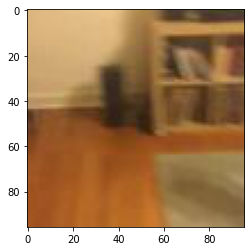

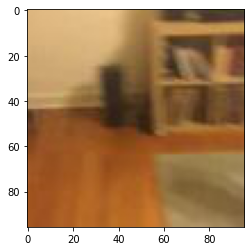

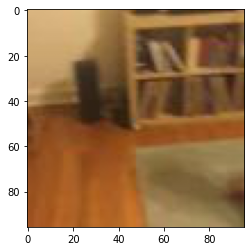

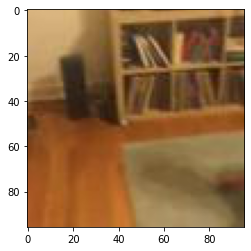

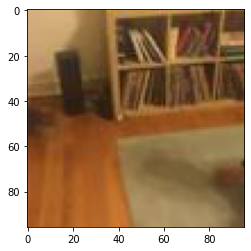

In [9]:
figure()
imshow(videos[0][:,:,0:3])
figure()
imshow(videos[0][:,:,3:6])
figure()
imshow(videos[0][:,:,6:9])
figure()
imshow(videos[0][:,:,12:15])

figure()
imshow(next_frame[0][:,:,0:3])

In [10]:
def perceptual_distance(y_true, y_pred):
    y_true *= 255.
    y_pred *= 255.
    rmean = (y_true[:, :, :, 0] + y_pred[:, :, :, 0]) / 2
    r = y_true[:, :, :, 0] - y_pred[:, :, :, 0]
    g = y_true[:, :, :, 1] - y_pred[:, :, :, 1]
    b = y_true[:, :, :, 2] - y_pred[:, :, :, 2]

    return K.mean(K.sqrt((((512+rmean)*r*r)/256) + 4*g*g + (((767-rmean)*b*b)/256)))

In [11]:
from keras.layers import TimeDistributed,ConvLSTM2D,ReLU,Reshape,GaussianNoise,Input,Lambda,MaxPooling2D
from keras.layers import UpSampling2D,add
from keras.models import Model
import wandb

In [ ]:
wandb.init(config = hyperparams)
config = wandb.config

def add1(x):                                           
  return x[:,:,:,:,-1]        

y = Input(shape = (config.height,config.width,5*3))
permute = Reshape((config.height,config.width,3,5))(y)
# noise = GaussianNoise(0.1)(permute)
permute_2 = Reshape((5,96,96,3))(permute)
lambd = Lambda(add1)(permute)

# inp = Input(shape=(config.height, config.width, 5 * 3))
down_1_LS = ConvLSTM2D(6,(3,3),padding='same',activation='relu',name='down_1_LS',return_sequences=True)(permute_2)
down1 = TimeDistributed(MaxPooling2D(pool_size=(2,2)),name = "down1")(down_1_LS)

down_2_LS = ConvLSTM2D(12,(3,3),padding='same',activation='relu',name='down_2_LS',return_sequences=True)(down1)
down2 = TimeDistributed(MaxPooling2D((2,2)),name ='down2')(down_2_LS)

down_3_LS = ConvLSTM2D(18,(3,3),padding='same', activation= 'relu',name = 'down_3_LS',return_sequences=True)(down2)
down3 = TimeDistributed(MaxPooling2D((2,2)),name = 'down3')(down_3_LS)

up_1_LS = ConvLSTM2D(18,(3,3),padding='same',activation = 'relu',name ='up_1_LS',return_sequences=True)(down3)
up1 = TimeDistributed(UpSampling2D((2,2)),name = 'up1')(up_1_LS)
up1 = add([up1,down_3_LS])

up_2_LS = ConvLSTM2D(12,(3,3),padding='same',activation = 'relu',name = 'up_2_LS',return_sequences=True)(up1)
up2 = TimeDistributed(UpSampling2D((2,2)),name = 'up2')(up_2_LS)
up2 = add([up2,down_2_LS])

up_3_LS = ConvLSTM2D(6,(3,3),padding='same',activation = 'relu',name = 'up_3_LS',return_sequences=True)(up2)
up3 = TimeDistributed(UpSampling2D((2,2)),name = 'up3')(up_3_LS)

reshape = ConvLSTM2D(3,(3,3),padding='same',activation='relu',name='reshape',return_sequences=True)(up3)
five_three = add([reshape,permute_2],name='five_three')

four_three = Reshape((96,96,15),name='four_three')(five_three)
last = Conv2D(3,(3,3),padding='same',activation = 'relu',name = 'last')(four_three)
lsat = add([lambd,last],name='lsat')


# re_up3 = Reshape((5,96,96,3))(up3)
# re_up3 = add([re_up3+permute_2])


# conv = Conv2D(3,(3,3),padding='same',activation='relu')(lstm)
# Norm = BatchNormalization()(conv)
# output = add([lambd,Norm])

model = Model(inputs= y,outputs= lsat)           

model.compile(optimizer='adam',loss='mse',metrics=[perceptual_distance])                            

model.fit_generator(my_generator(config.batch_size,train_dir),
                    steps_per_epoch=steps_per_epoch
                    ,epochs=config.num_epochs,callbacks=[WandbCallback(),ImageCallback()],
                    validation_steps = validation_steps1,
                    validation_data = my_generator(config.batch_size,val_dir))

In [ ]:
for layer in model.layers:
  print(layer.output)            

Tensor("input_16:0", shape=(None, 96, 96, 15), dtype=float32)
Tensor("reshape_33_1/Reshape:0", shape=(None, 96, 96, 3, 5), dtype=float32)
Tensor("reshape_34/Reshape:0", shape=(None, 5, 96, 96, 3), dtype=float32)
Tensor("down_1_LS_15/transpose_1:0", shape=(None, 5, 96, 96, 6), dtype=float32)
Tensor("down1_15/Reshape_1:0", shape=(None, 5, 48, 48, 6), dtype=float32)
Tensor("down_2_LS_15/transpose_1:0", shape=(None, 5, 48, 48, 12), dtype=float32)
Tensor("down2_15/Reshape_1:0", shape=(None, 5, 24, 24, 12), dtype=float32)
Tensor("down_3_LS_15/transpose_1:0", shape=(None, 5, 24, 24, 18), dtype=float32)
Tensor("down3_15/Reshape_1:0", shape=(None, 5, 12, 12, 18), dtype=float32)
Tensor("up_1_LS_15/transpose_1:0", shape=(None, 5, 12, 12, 18), dtype=float32)
Tensor("up1_15/Reshape_1:0", shape=(None, 5, 24, 24, 18), dtype=float32)
Tensor("add_22/add:0", shape=(None, 5, 24, 24, 18), dtype=float32)
Tensor("up_2_LS_13/transpose_1:0", shape=(None, 5, 24, 24, 12), dtype=float32)
Tensor("up2_13/Reshape_1